In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import os

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("NYC_Taxi_Analysis") \
    .master("spark://spark-master:7077") \
    .config("spark.sql.legacy.parquet.datetimeRebaseModeInRead", "LEGACY") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200")  \
    .config("spark.sql.files.maxPartitionBytes", "256m") \
    .getOrCreate()

25/01/30 17:03:23 WARN Utils: Your hostname, adminui-MacBookPro-63.local resolves to a loopback address: 127.0.0.1; using 172.29.123.233 instead (on interface en0)
25/01/30 17:03:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/30 17:03:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
data_dir = "./data/NYC-TLC"
parquet_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".parquet")]

# 모든 Parquet 파일을 하나의 DataFrame으로 로드
df = spark.read.parquet(*parquet_files)

# 스키마 확인
df.printSchema()

25/01/30 17:03:24 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.
25/01/30 17:03:24 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.
25/01/30 17:03:24 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.


root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [5]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|            1.0|          1.2|       1.0|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.4

In [6]:
df = df.drop("airport_fee")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|            1.0|          1.2|       1.0|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [7]:
# 컬럼별 결측값 개수 계산
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       0|                   0|                    0|        3656965|            0|   3656965|           3656965|           0|           0|           0|          0|    0|      0|         0|           0|                    0

In [8]:
print(f"Before dropna: {df.count()} rows")
df_cleaned = df.dropna()
print(f"After dropna: {df_cleaned.count()} rows")

Before dropna: 95209498 rows


After dropna: 91552533 rows


In [9]:
df_cleaned = df_cleaned.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
df_cleaned = df_cleaned.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|            1.0|          1.2|       1.0|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [10]:
df_invalid_time = df_cleaned.filter(col("tpep_dropoff_datetime") < col("tpep_pickup_datetime"))
print(f"Invalid time rows: {df_invalid_time.count()} rows")
df_invalid_time.show(truncate=False)

Invalid time rows: 1466 rows


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|1       |2020-01-04 08:19:55 |2020-01-02 10:09:33  |1.0            |3.5          |1.0       |N                 |107         |237         |1           |16.5       |2.5  |0.5    |4.95      |0.0         |0.3                  

In [11]:
numeric_cols = [
    "passenger_count", "trip_distance", "RatecodeID", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "total_amount", "congestion_surcharge"
]

df_invalid_values = df_cleaned.filter(
    " OR ".join([f"{col_name} < 0" for col_name in numeric_cols])
)

print(f"Invalid value rows: {df_invalid_values.count()} rows")
df_invalid_values.show(truncate=False)

Invalid value rows: 486876 rows
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|2       |2020-01-01 00:54:28 |2020-01-01 00:58:41  |1.0            |0.6          |1.0       |N                 |170         |137         |3           |-4.5       |-0.5 |-0.5   |0.0       |0.

In [12]:
df_cleaned = df_cleaned.filter(col("tpep_dropoff_datetime") >= col("tpep_pickup_datetime"))

In [13]:
df_cleaned = df_cleaned.filter(
    " AND ".join([f"{col_name} >= 0" for col_name in numeric_cols])
)

In [14]:
print(f"Total rows after cleaning: {df_cleaned.count()}")
df_cleaned.show(5, truncate=False)

Total rows after cleaning: 91064198
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|1       |2020-01-01 00:28:15 |2020-01-01 00:33:03  |1.0            |1.2          |1.0       |N                 |238         |239         |1           |6.0        |3.0  |0.5    |1.47     

In [15]:
df_cleaned = df_cleaned.withColumn(
    "trip_duration", 
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime")))
)

avg_trip_duration = df_cleaned.select(avg(col("trip_duration"))).collect()[0][0]
avg_trip_duration_minutes = avg_trip_duration / 60  # 초 → 분 변환

avg_trip_distance = df_cleaned.select(avg(col("trip_distance"))).collect()[0][0]

In [16]:
result = f"""
📊 **뉴욕 택시 데이터 분석 결과 (Yellow Taxi (2020~2022))** 📊

🚕 **평균 이동 시간:** {avg_trip_duration_minutes:.2f} 분  
📏 **평균 이동 거리:** {avg_trip_distance:.2f} 마일  

🚀 데이터 정리 완료! 🎉
"""

print(result)


📊 **뉴욕 택시 데이터 분석 결과 (Yellow Taxi (2020~2022))** 📊

🚕 **평균 이동 시간:** 31.06 분  
📏 **평균 이동 거리:** 3.18 마일  

🚀 데이터 정리 완료! 🎉



In [17]:
df_cleaned = df_cleaned.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

hourly_rides = df_cleaned.groupBy("pickup_hour").agg(count("*").alias("ride_count"))
hourly_rides = hourly_rides.orderBy("pickup_hour")

hourly_rides_pd = hourly_rides.toPandas()


In [18]:
import matplotlib.pyplot as plt

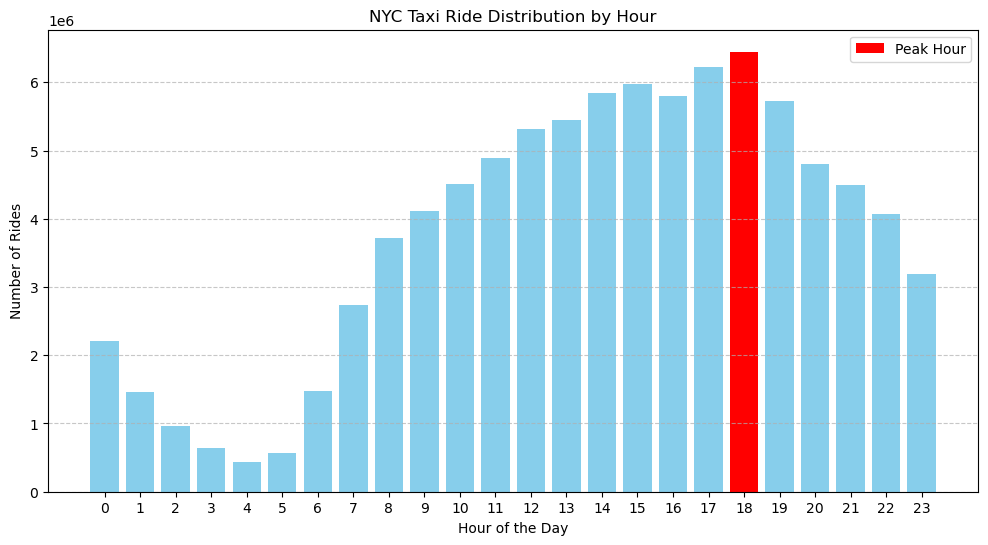

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(hourly_rides_pd["pickup_hour"], hourly_rides_pd["ride_count"], color="skyblue")

# 혼잡 시간대 강조
peak_hour = hourly_rides_pd.loc[hourly_rides_pd["ride_count"].idxmax()]
plt.bar(peak_hour["pickup_hour"], peak_hour["ride_count"], color="red", label="Peak Hour")

plt.xticks(range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("NYC Taxi Ride Distribution by Hour")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [20]:
weather_df = spark.read.csv("data/nyc_weather.csv", header=True, inferSchema=True)

weather_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- precipitation: double (nullable = true)



25/01/30 17:04:25 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.


In [21]:
df_cleaned = df_cleaned.withColumn("date", to_date(col("tpep_pickup_datetime")))
weather_df = weather_df.withColumn("avg_temp", (col("temp_max") + col("temp_min")) / 2)

In [22]:
merged_df = df_cleaned.join(weather_df, on="date", how="inner")

In [23]:
merged_df = merged_df.withColumn(
    "temp_category",
    when(col("avg_temp") < 0, "Under 0°C")
    .when((col("avg_temp") >= 0) & (col("avg_temp") < 10), "0~10°C")
    .when((col("avg_temp") >= 10) & (col("avg_temp") < 20), "10~20°C")
    .when((col("avg_temp") >= 20) & (col("avg_temp") < 30), "20~30°C")
    .otherwise("Over 30°C")
)


In [24]:
merged_df = merged_df.withColumn(
    "precip_category",
    when(col("precipitation") == 0, "No Rain")
    .when((col("precipitation") > 0) & (col("precipitation") <= 2), "Light Rain (0~2mm)")
    .when((col("precipitation") > 2) & (col("precipitation") <= 10), "Moderate Rain (2~10mm)")
    .otherwise("Heavy Rain (over 10mm)")
)

In [25]:
merged_df.show(5)

25/01/30 17:04:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------+-----------+--------+--------+-------------+--------+-------------+---------------+
|      date|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|trip_duration|pickup_hour|temp_max|temp_min|precipitation|avg_temp|temp_category|precip_category|
+----------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------

In [26]:
temp_vs_rides = merged_df.groupBy("temp_category").agg(count("*").alias("ride_count"))

precip_vs_rides = merged_df.groupBy("precip_category").agg(count("*").alias("ride_count"))

In [27]:
temp_corr = merged_df.stat.corr("avg_temp", "trip_distance")
precip_corr = merged_df.stat.corr("precipitation", "trip_distance")

print(f"기온과 이동 거리의 상관계수: {temp_corr}")
print(f"강수량과 이동 거리의 상관계수: {precip_corr}")

기온과 이동 거리의 상관계수: 0.0030389162373513604
강수량과 이동 거리의 상관계수: -1.7225672640443455e-05


In [28]:
import seaborn as sns

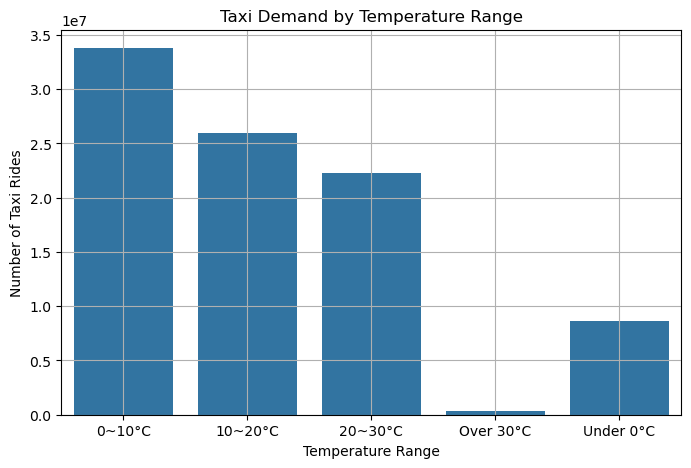

In [29]:
temp_vs_rides_pd = temp_vs_rides.toPandas().sort_values("temp_category")
plt.figure(figsize=(8, 5))
sns.barplot(x="temp_category", y="ride_count", data=temp_vs_rides_pd)
plt.xlabel("Temperature Range")
plt.ylabel("Number of Taxi Rides")
plt.title("Taxi Demand by Temperature Range")
plt.grid()
plt.show()

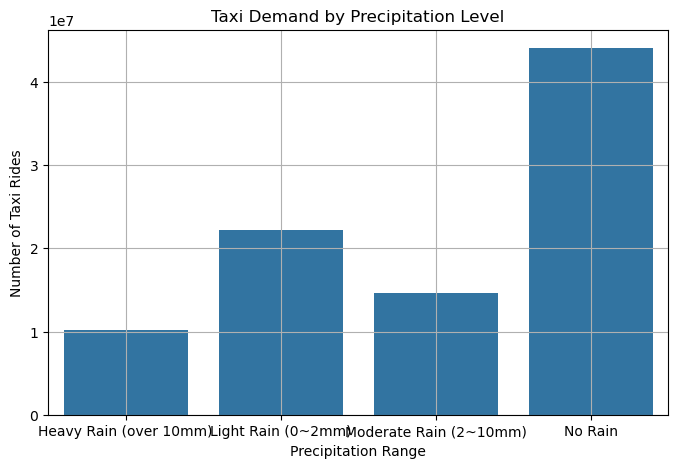

In [30]:
precip_vs_rides_pd = precip_vs_rides.toPandas().sort_values("precip_category")
plt.figure(figsize=(8, 5))
sns.barplot(x="precip_category", y="ride_count", data=precip_vs_rides_pd)
plt.xlabel("Precipitation Range")
plt.ylabel("Number of Taxi Rides")
plt.title("Taxi Demand by Precipitation Level")
plt.grid()
plt.show()

In [31]:
rides_per_day_temp = (
    merged_df.groupBy("temp_category", "date")
    .agg(count("*").alias("daily_rides"))
    .groupBy("temp_category")
    .agg(avg("daily_rides").alias("avg_daily_rides"))
)

rides_per_day_precip = (
    merged_df.groupBy("precip_category", "date")
    .agg(count("*").alias("daily_rides"))
    .groupBy("precip_category")
    .agg(avg("daily_rides").alias("avg_daily_rides"))
)

In [32]:
avg_trip_distance_temp = merged_df.groupBy("temp_category").agg(avg("trip_distance").alias("avg_trip_distance"))

avg_trip_distance_precip = merged_df.groupBy("precip_category").agg(avg("trip_distance").alias("avg_trip_distance"))

In [33]:
rides_per_day_temp_pd = rides_per_day_temp.toPandas().sort_values("temp_category")
rides_per_day_precip_pd = rides_per_day_precip.toPandas().sort_values("precip_category")
avg_trip_distance_temp_pd = avg_trip_distance_temp.toPandas().sort_values("temp_category")
avg_trip_distance_precip_pd = avg_trip_distance_precip.toPandas().sort_values("precip_category")

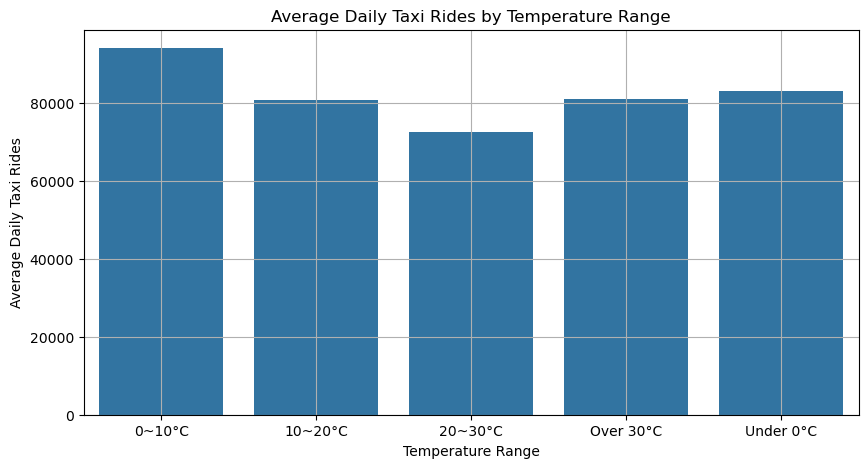

In [34]:
plt.figure(figsize=(10, 5))
sns.barplot(x="temp_category", y="avg_daily_rides", data=rides_per_day_temp_pd)
plt.xlabel("Temperature Range")
plt.ylabel("Average Daily Taxi Rides")
plt.title("Average Daily Taxi Rides by Temperature Range")
plt.grid()
plt.show()

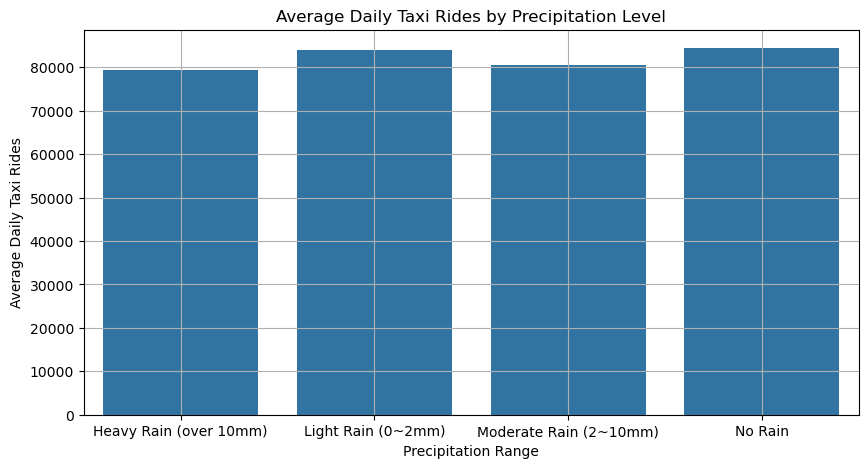

In [35]:
plt.figure(figsize=(10, 5))
sns.barplot(x="precip_category", y="avg_daily_rides", data=rides_per_day_precip_pd)
plt.xlabel("Precipitation Range")
plt.ylabel("Average Daily Taxi Rides")
plt.title("Average Daily Taxi Rides by Precipitation Level")
plt.grid()
plt.show()

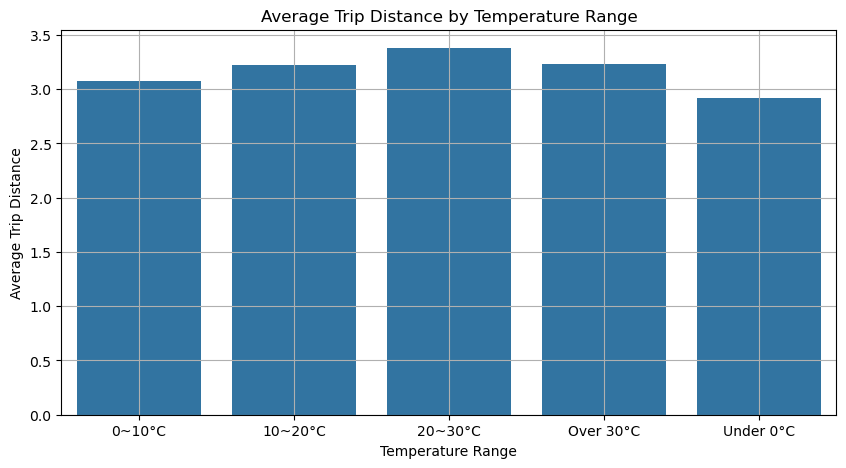

In [36]:

plt.figure(figsize=(10, 5))
sns.barplot(x="temp_category", y="avg_trip_distance", data=avg_trip_distance_temp_pd)
plt.xlabel("Temperature Range")
plt.ylabel("Average Trip Distance")
plt.title("Average Trip Distance by Temperature Range")
plt.grid()
plt.show()

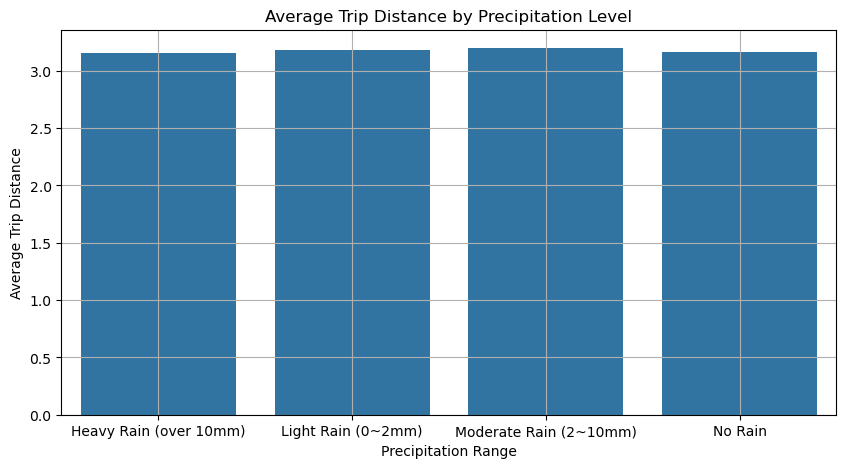

In [37]:
plt.figure(figsize=(10, 5))
sns.barplot(x="precip_category", y="avg_trip_distance", data=avg_trip_distance_precip_pd)
plt.xlabel("Precipitation Range")
plt.ylabel("Average Trip Distance")
plt.title("Average Trip Distance by Precipitation Level")
plt.grid()
plt.show()

In [48]:
import os
from pyspark.sql import SparkSession

# 결과 저장 경로
output_dir = "data/output/"
os.makedirs(output_dir, exist_ok=True)

# 평균 이동 시간 & 거리 저장
avg_trip_duration_df = spark.createDataFrame([(avg_trip_duration,)], ["avg_trip_duration"])
avg_trip_duration_df.coalesce(1).write.csv(os.path.join(output_dir, "avg_trip_duration.csv"), header=True, mode="overwrite")

avg_trip_distance_df = spark.createDataFrame([(avg_trip_distance,)], ["avg_trip_distance"])
avg_trip_distance_df.coalesce(1).write.csv(os.path.join(output_dir, "avg_trip_distance.csv"), header=True, mode="overwrite")

# 🔹 peak_hour: Series → int 변환 후 저장
peak_hour_value = int(peak_hour.iloc[0])  # Series에서 단일 값 가져오기
peak_hour_df = spark.createDataFrame([(peak_hour_value,)], ["peak_hour"])
peak_hour_df.coalesce(1).write.csv(os.path.join(output_dir, "peak_hour.csv"), header=True, mode="overwrite")

# 🔹 rides_per_day_temp_pd: Pandas DataFrame 저장
rides_per_day_temp_pd.to_csv(os.path.join(output_dir, "rides_per_day_temp.csv"), index=False)

# 🔹 rides_per_day_precip_pd: Pandas DataFrame 저장
rides_per_day_precip_pd.to_csv(os.path.join(output_dir, "rides_per_day_precip.csv"), index=False)

# 🔹 avg_trip_distance_temp_pd: Pandas DataFrame 저장
avg_trip_distance_temp_pd.to_csv(os.path.join(output_dir, "avg_trip_distance_temp.csv"), index=False)

# 🔹 avg_trip_distance_precip_pd: Pandas DataFrame 저장
avg_trip_distance_precip_pd.to_csv(os.path.join(output_dir, "avg_trip_distance_precip.csv"), index=False)

print("All analysis results saved to data/output/")

All analysis results saved to data/output/
